<a href="https://colab.research.google.com/github/M-Amrollahi/Personal-Notes/blob/master/ML-notes/simple_nn_transform_data_by_fransisF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
import math
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay

from collections import OrderedDict

In [3]:
def f_create_dataset():
    torch.manual_seed(0)

    nb = 1000
    x = torch.rand(nb, 2) * torch.tensor([math.pi * 1.5, 0.10]) + torch.tensor(
        [math.pi * -0.25, 0.25]
    )

    train_targets = (torch.rand(nb) < 0.5).long()

    train_input = torch.cat((x[:, 0:1].sin() * x[:, 1:2], x[:, 0:1].cos() * x[:, 1:2]), 1)
    train_input[:, 0] *= train_targets * 2 - 1
    train_input[:, 0] += 0.05 * (train_targets * 2 - 1)
    train_input[:, 1] -= 0.15 * (train_targets * 2 - 1)
    train_input *= 1.2

    return train_input, train_targets

In [4]:
train_input, train_targets = f_create_dataset()

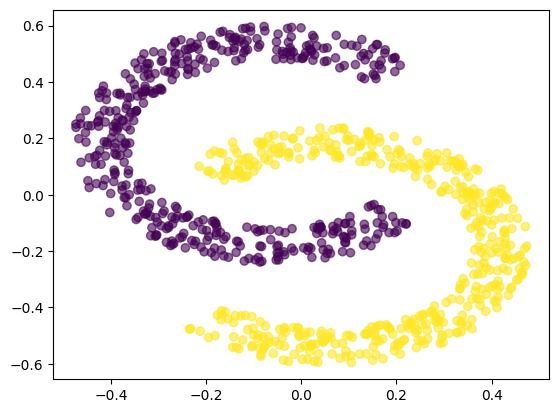

In [5]:
plt.scatter(train_input[:-100,0], train_input[:-100,1],c=train_targets[:-100],alpha=.6)

In [6]:
@torch.no_grad()
def f_eval(model, data):
    model.eval()

    lst_res = []
    for i, x in enumerate(data):
        y_pred = model.forward(x[:,:2])


        lst_res.append(torch.vstack((y_pred.argmax(dim=1), x[:,2])))

    res = torch.hstack(lst_res).numpy()

    model.train()
    return res

Train Loss: 1.904641, Test Acc: 38.0%
Train Loss: 1.171389, Test Acc: 48.0%
Train Loss: 0.775247, Test Acc: 66.0%
Train Loss: 0.679216, Test Acc: 74.0%
Train Loss: 0.649182, Test Acc: 76.0%
Train Loss: 0.629758, Test Acc: 76.0%
Train Loss: 0.625200, Test Acc: 76.0%
Train Loss: 0.618719, Test Acc: 74.0%
Train Loss: 0.609262, Test Acc: 76.0%
Train Loss: 0.575686, Test Acc: 78.0%
Train Loss: 0.545785, Test Acc: 78.0%
Train Loss: 0.520027, Test Acc: 82.0%
Train Loss: 0.492762, Test Acc: 82.0%
Train Loss: 0.489881, Test Acc: 84.0%
Train Loss: 0.485872, Test Acc: 84.0%
Train Loss: 0.479979, Test Acc: 84.0%
Train Loss: 0.471527, Test Acc: 86.0%
Train Loss: 0.450842, Test Acc: 86.0%
Train Loss: 0.365078, Test Acc: 96.0%
Train Loss: 0.174024, Test Acc: 100.0%


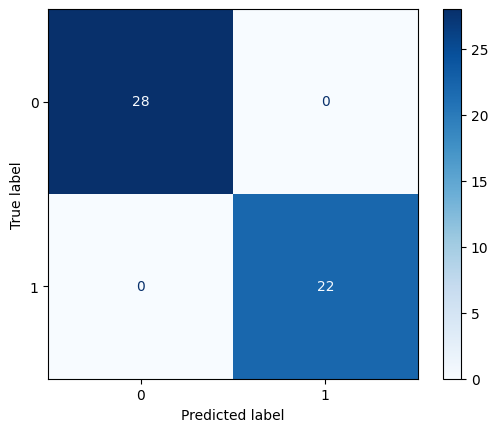

In [41]:
#model = cls_model()
model = nn.Sequential(
            nn.Sequential(nn.Linear(2, 2, bias=False), nn.Tanh()),
            nn.Sequential(nn.Linear(2, 2, bias=False), nn.Tanh()),
            nn.Sequential(nn.Linear(2, 2, bias=False), nn.Tanh()),
            nn.Sequential(nn.Linear(2, 2, bias=False), nn.Tanh()),
            nn.Sequential(nn.Linear(2, 2, bias=False), nn.Tanh()),
            nn.Sequential(nn.Linear(2, 2, bias=False), nn.Tanh()),
            nn.Sequential(nn.Linear(2, 2, bias=False), nn.Tanh()),
            nn.Sequential(nn.Linear(2, 2, bias=False), nn.Tanh()),
            nn.Sequential(nn.Linear(2, 2)),)
with torch.no_grad():
    for m in model.modules():
        if isinstance(m, nn.Linear):
            #nn.init.xavier_normal( m.weight)

            m.weight[...] = 2 * torch.eye(2) + torch.randn(2, 2) * 1e-4

dl_train = DataLoader(torch.hstack((train_input[:-50], train_targets[:-50].unsqueeze(dim=1))),25)
dl_test = DataLoader(torch.hstack((train_input[-50:], train_targets[-50:].unsqueeze(dim=1))),25)

optim = torch.optim.Adam(model.parameters(), lr=7e-3)
criterion = torch.nn.CrossEntropyLoss()

lst_res = []

epochs= 20
model.train()

for i in range(epochs):
    lst_out = []
    total_loss = 0
    for j ,(data) in enumerate(dl_train):
        optim.zero_grad()

        logits = model.forward(data[:,:2])
        loss = criterion.forward(logits, data[:,2].long())

        loss.backward()

        optim.step()

        lst_out.append(torch.hstack((logits,data[:,2].unsqueeze(dim=1))))
        total_loss += loss.item()

    output = f_eval(model, dl_test)


    acc = accuracy_score( output[1], output[0])
    print(f"Train Loss: {(total_loss/j if j!=0 else 1):04f}, Test Acc: {acc*100}%")
    lst_res.append(torch.vstack(lst_out))

conf_mx = confusion_matrix(output[1], output[0])
ConfusionMatrixDisplay(conf_mx).plot(cmap=plt.cm.Blues)


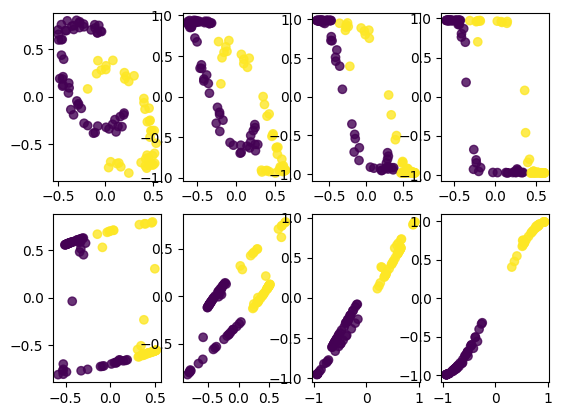

In [42]:
lst_res = []
fig, axs = plt.subplots(2, 4)

dl_test = DataLoader(torch.hstack((train_input[-100:], train_targets[-100:].unsqueeze(dim=1))),8)

model.eval()
for m in model.children():
    if type(m) != type(nn.Sequential()):
        continue

    lst_tmp = []
    for x in dl_test:
        tt = m.forward(x[:,:2])
        lst_tmp.append(torch.hstack( (tt, x[:,2].unsqueeze(dim=1))))

    output = torch.vstack(lst_tmp)

    dl_test = DataLoader(output)
    lst_res.append(output)


for i in range(2):
    for j in range(4):
        axs[i][j].scatter(lst_res[i*4+j][:,0].detach().numpy(), lst_res[i*4+j][:,1].detach().numpy(), c=lst_res[i*4+j][:,2].detach().numpy(), alpha=.8)

plt.show()